In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import argparse, cv2, logging, pdb
import matplotlib.pyplot as plt, numpy as np
import focus_stacking.registration.ecc as ecc
import focus_stacking.utils.images as im_utils
import focus_stacking.utils.data_loader as data_loader
from focus_stacking.utils.pyramids import StackPyramid, Pyramid
import focus_stacking.utils.pyramids
import focus_stacking.energy.energy as energies
import focus_stacking.fusion.fusion as fusion

align_max_iters = 50
align_eps = 1e-3
DATA_ROOT = '/n/fs/3d-indoor/macro_data/focus_stacks'

logger = logging.getLogger(__name__)


In [48]:
aux_out_dir = '/n/fs/3d-indoor/tmp_outdir/aux/'
registered_images = data_loader.load_images_from_dir(aux_out_dir, match='reg_*.jpg')

In [49]:
ksize=5
low_pass_kernel = cv2.getGaussianKernel(ksize, sigma=-1)
# low_pass_kernel = np.array([0.25 - (.4/2.), .25, .4, .25, .25-(.4 / 2.)])
down_pyramid = StackPyramid(registered_images, levels=5, kernel=low_pass_kernel, pyramid_type='laplacian')

making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid


In [50]:
low_pass_kernel

array([[0.0625],
       [0.25  ],
       [0.375 ],
       [0.25  ],
       [0.0625]])

In [51]:
low_pass_kernel = cv2.getGaussianKernel(ksize, sigma=-1)
low_pass_kernel

array([[0.0625],
       [0.25  ],
       [0.375 ],
       [0.25  ],
       [0.0625]])

In [52]:
np.outer(low_pass_kernel,low_pass_kernel) * 256

array([[ 1.,  4.,  6.,  4.,  1.],
       [ 4., 16., 24., 16.,  4.],
       [ 6., 24., 36., 24.,  6.],
       [ 4., 16., 24., 16.,  4.],
       [ 1.,  4.,  6.,  4.,  1.]])

In [65]:
for pyramid in down_pyramid.pyramids:
    pyramid.compute_energy_for_levels(-1, 'laplacian', 'entropy', ksize=ksize)
    pyramid.compute_energy_for_levels(-1, 'laplacian', 'deviation', ksize=ksize)
    pyramid.compute_energy_for_levels(-1, 'laplacian', 'variance', ksize=ksize)
    for level_id in range(pyramid.num_levels-1):
        pyramid.compute_energy_for_levels(level_id, 'laplacian', 'region', kernel=low_pass_kernel)

[[165.047    165.047    165.047    ... 128.707    128.707    128.006   ]
 [165.047    165.047    165.047    ... 129.006    128.12     128.006   ]
 [165.047    165.047    165.047    ... 128.707    128.707    128.892   ]
 ...
 [ 75.635994  75.635994  75.337    ... 217.40602  213.819    210.819   ]
 [ 76.223     76.223     76.223    ... 217.40602  214.52     211.819   ]
 [ 75.521996  76.223     76.337    ... 218.406    216.107    213.406   ]]
[[164.862    164.862    164.57399  ... 128.892    128.006    120.185   ]
 [164.161    164.161    164.45999  ... 128.892    128.006    120.185   ]
 [164.161    164.161    164.161    ... 128.593    128.006    120.772   ]
 ...
 [ 75.739     75.625     75.625    ... 217.10701  213.819    210.819   ]
 [ 75.625     75.625     75.81     ... 217.40602  214.406    211.819   ]
 [ 75.625     75.923996  75.923996 ... 218.406    216.107    213.406   ]]
[[ 91.077995 142.878    163.574    ... 126.832    117.712006  52.823   ]
 [ 92.779    142.992    163.574    ... 

[[  0.587   0.587   0.299 ...   0.      0.      0.   ]
 [  0.587   0.587   0.299 ...   0.      0.      0.   ]
 [  0.587   0.587   0.299 ...   0.      0.      0.   ]
 ...
 [ 74.739  73.739  72.739 ... 226.879 226.879 226.879]
 [ 73.739  71.739  71.739 ... 226.879 226.879 226.879]
 [ 72.739  70.739  71.739 ... 226.879 226.879 226.879]]


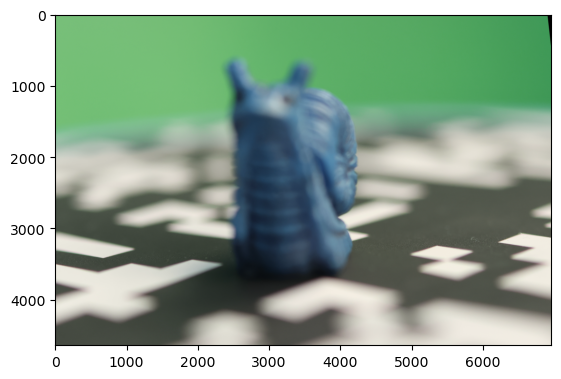

In [81]:
pyramid.compute_energy_for_levels(0, 'image', 'variance', ksize=ksize)
pyramid.compute_energy_for_levels(0, 'image', 'deviation', ksize=ksize)
plt.imshow(pyramid.levels[0]['image'])

In [86]:
var = energies.local_variance(pyramid.levels[0]['image'], 5)
var.min(), var.max()

[[0.00230196 0.00230196 0.00117255 ... 0.         0.         0.        ]
 [0.00230196 0.00230196 0.00117255 ... 0.         0.         0.        ]
 [0.00230196 0.00230196 0.00117255 ... 0.         0.         0.        ]
 ...
 [0.2930941  0.28917253 0.28525096 ... 0.8897216  0.8897216  0.8897216 ]
 [0.28917253 0.2813294  0.2813294  ... 0.8897216  0.8897216  0.8897216 ]
 [0.28525096 0.27740782 0.2813294  ... 0.8897216  0.8897216  0.8897216 ]]


(-5.9604645e-08, 0.090933554)

In [80]:
pyramid.levels[0]['deviation'].min(), pyramid.levels[0]['deviation'].max()

(0.0, 3742.9858)

In [78]:
pyramid.levels[0]['variance'].min(), pyramid.levels[0]['variance'].max()

(-2.2737367e-15, 2711.5835)

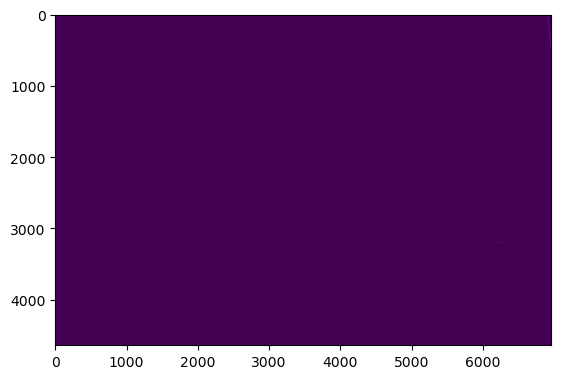

In [76]:
plt.imshow(pyramid.levels[0]['variance'])

In [66]:
pyramid.levels[-1]['deviation']

array([[8.25496155e+02, 7.50508362e+02, 7.49924194e+02, ...,
        6.16473389e+02, 8.13718018e+02, 6.32225098e+02],
       [7.81669250e+02, 7.10887329e+02, 7.10225159e+02, ...,
        6.27202454e+02, 8.26824951e+02, 6.50975037e+02],
       [6.52587280e+02, 5.92917847e+02, 5.92190552e+02, ...,
        6.56099182e+02, 8.57433777e+02, 6.95129517e+02],
       ...,
       [1.32205039e-01, 1.16676077e-01, 1.02467865e-01, ...,
        2.51219809e-01, 2.04113841e-01, 2.07590654e-01],
       [1.23773523e-01, 1.09110661e-01, 9.63225812e-02, ...,
        2.06736654e-01, 1.58074006e-01, 1.58799499e-01],
       [1.06574938e-01, 9.55747515e-02, 8.33522305e-02, ...,
        2.33663350e-01, 1.67101204e-01, 1.63693920e-01]], dtype=float32)

In [70]:
(pyramid.levels[-1]['variance'] - pyramid.levels[-1]['deviation']).mean()

90.185745

In [54]:
base_ims = [pyramid.levels[-1]['laplacian'] for pyramid in down_pyramid.pyramids]
base_entropy = [pyramid.levels[-1]['entropy'] for pyramid in down_pyramid.pyramids]
base_variance = [pyramid.levels[-1]['deviation'] for pyramid in down_pyramid.pyramids]
fused_base = fusion.fuse_multiple_max([base_entropy, base_variance], base_ims)
# fused_base = fusion.fuse_max(base_variance, base_ims)

In [55]:
result = im_utils.bgr_to_rgb(fused_base)/255
plt.imsave('new_base.png', result)

In [56]:
fused_layers = []
for level in range(down_pyramid.pyramids[0].num_levels-1):
    print(level)
    fuse_layer = fusion.fuse_max([pyramid.levels[level]['region'] for pyramid in down_pyramid.pyramids],
                                [pyramid.levels[level]['laplacian'].astype(np.float32) for pyramid in down_pyramid.pyramids])
    fused_layers.append(fuse_layer)
fused_layers.append(fused_base)

0
1
2
3


In [57]:
reconstruction_layers = [{'laplacian': fused_layer} for fused_layer in fused_layers]

In [58]:
from focus_stacking.utils.pyramids import LaplacianPyramid
reconstruction_pyramid = LaplacianPyramid(levels=reconstruction_layers, kernel=low_pass_kernel)

[[[ 40.21875    63.65625    41.28125  ]
  [ 85.5625    135.4375     88.3125   ]
  [127.75      204.484375  132.0625   ]
  ...
  [ 55.0625    126.375      74.75     ]
  [ 22.765625   51.5        30.21875  ]
  [  5.         11.875       7.375    ]]

 [[ 40.6875     65.6875     41.6875   ]
  [ 88.125     139.625      89.875    ]
  [128.5       204.96875   131.875    ]
  ...
  [ 55.125     127.5        74.75     ]
  [ 22.78125    52.4375     31.125    ]
  [  5.         11.75        7.25     ]]

 [[ 44.40625    69.4375     44.359375 ]
  [ 93.0625    146.75       94.84375  ]
  [128.8671875 205.796875  131.34375  ]
  ...
  [ 56.21875   128.625      75.71875  ]
  [ 23.7578125  54.140625   31.7890625]
  [  4.9375     12.3125      6.8125   ]]

 ...

 [[ 72.1875     77.8125     71.1875   ]
  [ 72.125      77.625      70.125    ]
  [ 73.         78.34375    71.       ]
  ...
  [223.        216.        207.       ]
  [221.        214.        206.       ]
  [220.        212.        205.       ]]

 [

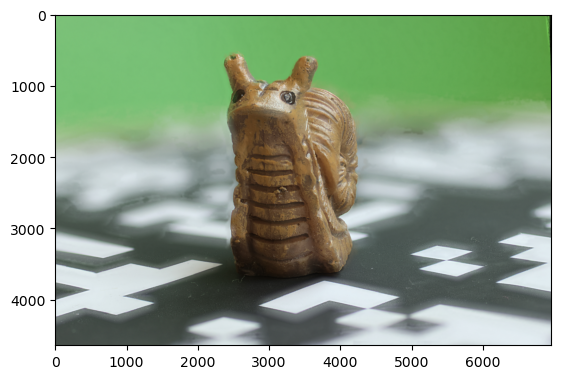

In [59]:
fused_im = reconstruction_pyramid.reconstruct()
# result = np.clip(im_utils.bgr_to_rgb(fused_im) / 255, 0, 1)
result = im_utils.bgr_to_rgb(fused_im) / 255
plt.imshow(result)

In [60]:
result.min(), result.max()

(-0.7814357383578432, 1.085436357236376)

In [61]:
plt.imsave('fused_new.png', np.clip(result, 0, 1))

In [51]:
import focus_stacking.methods.focus_stacking.focus_stack.pyramid as stk

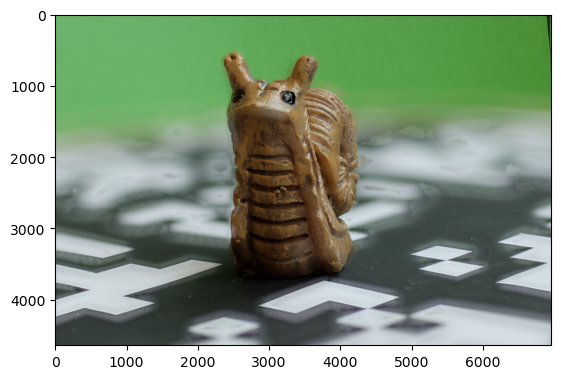

In [53]:
res = stk.collapse(fused_layers)
res = im_utils.bgr_to_rgb(cv2.convertScaleAbs(res))
plt.imshow(res)